# Coloring states of the US with cartopy and NetworkX
### Satyaki Sikdar 
#### <ssikdar@nd.edu>

Requires 
1. `matplotlib`
1. `Cartopy`
3. `NetworkX`

In [24]:
%matplotlib inline  # for jupyter notebooks only

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import networkx as nx
import warnings

warnings.filterwarnings('ignore')

In [18]:
plt.rcParams["figure.figsize"] = (50, 40)  # sets the size of plots for scripts, set to 16"x9" or similar

In [19]:
def plot_states(include='all'):
    G = nx.read_edgelist('states.txt', delimiter=',')  # read the neighborhood graph edgelist
    G.remove_nodes_from(['AK', 'HI'])  # remove Alaska and Hawaii
    
    if include == 'all':
        include = list(G.nodes_iter())  # include all the states (except AK and HI)
    G = G.subgraph(include)
    
    ax = plt.axes(projection=ccrs.PlateCarree())  # projection
    ax.add_feature(cfeature.STATES)  # draws the state borders 

    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lakes')  # reads the shapefile for states
    
    reader = shpreader.Reader(shpfilename)
    states = reader.records()
    states = [state for state in states if state.attributes['postal'] not in ('HI', 'AK')]  # removes AK and HI
    
    lon_lim = [float('inf'), float('-inf')]  # the lon and lat_lim stores the min & max lat longs in the set  
    lat_lim = [float('inf'), float('-inf')]

    ## finds the axes limits using the max and min lat longs
    for state in states:
        state_name = state.attributes['postal']
        if state_name not in include:
            continue
        lat = state.attributes['latitude']
        lat_lim = [min(lat_lim[0], lat), max(lat_lim[1], lat)]

        lon = state.attributes['longitude']
        lon_lim = [min(lon_lim[0], lon), max(lon_lim[1], lon)]

    lon_lim[0] -= 5  # for extra space
    lon_lim[1] += 5  # ditto
    
    lat_lim[0] -= 4
    lat_lim[1] += 4
    
    extent = [*lon_lim, *lat_lim]  
    ax.set_extent(extent)   # sets the extent
    
    
    cmap = {0: '#ff6666', 1: '#668cff', 2: '#66ff99', 3: '#ffff80'}  # map of colors - red, blue, green, yellow
    colors = nx.greedy_color(G, strategy=nx.coloring.strategy_smallest_last)  # does the graph coloring 
    colors = dict((k, cmap[v]) for k, v in colors.items())  # sets the graph colors into actual colors
    
    pos = {}  # dict for node positions
    for state in states:
        state_name = state.attributes['postal']
        if state_name not in include:
            continue
        if len(include) == G.order():  # for the whole country, print the postal abbreviations
            name = state_name
        else:  # for a region, use whole state names
            name = state.attributes['name']
        plt.text(state.attributes['longitude'] + 0.1, state.attributes['latitude'] + 0.1, name,
                fontsize=35, fontweight='bold')  # writing the state names
        
        pos[state_name] = (state.attributes['longitude'] - 0.1, state.attributes['latitude'] - 0.1)  # sets the positions
        
    for state in list(states):
        state_name = state.attributes['postal']
        if state_name not in include:
            continue
        ax.add_geometries(state.geometry, ccrs.PlateCarree(),
                              facecolor=colors[state_name], edgecolor='b', alpha=0.7)  # colors the states 


    nx.draw_networkx_nodes(G, pos, node_color='k', node_size=2000)  # draws the network nodes
    nx.draw_networkx_edges(G, pos, width=5)  # draws the edges

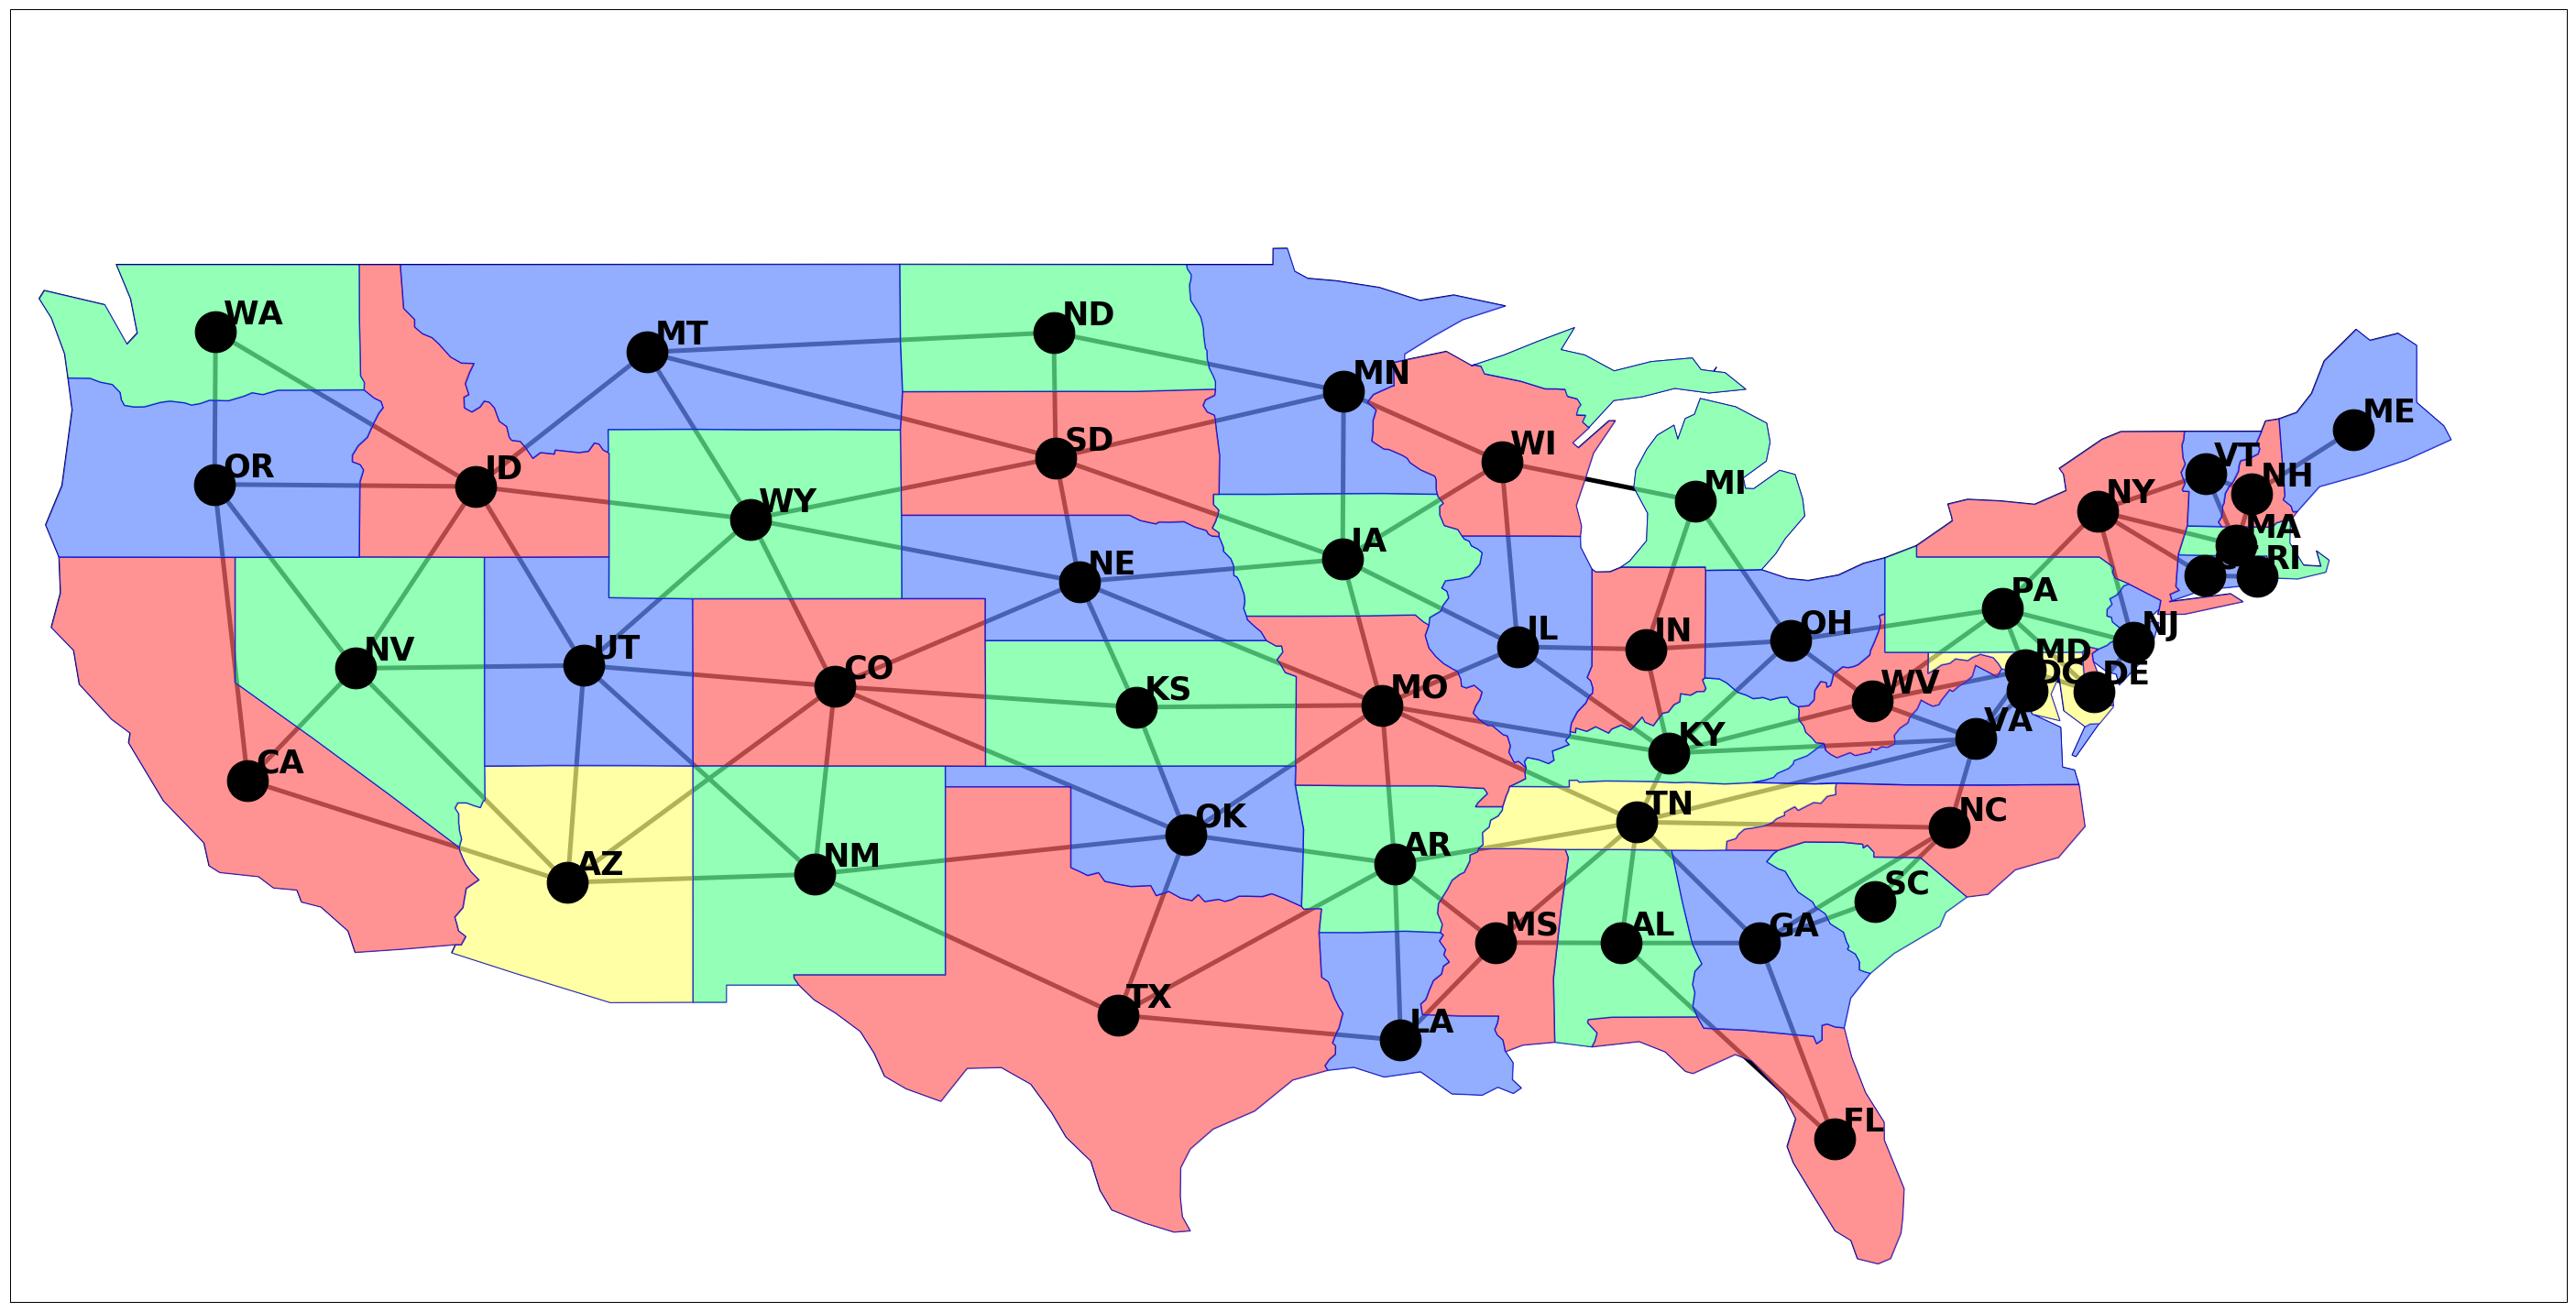

In [20]:
# the whole country
plot_states()

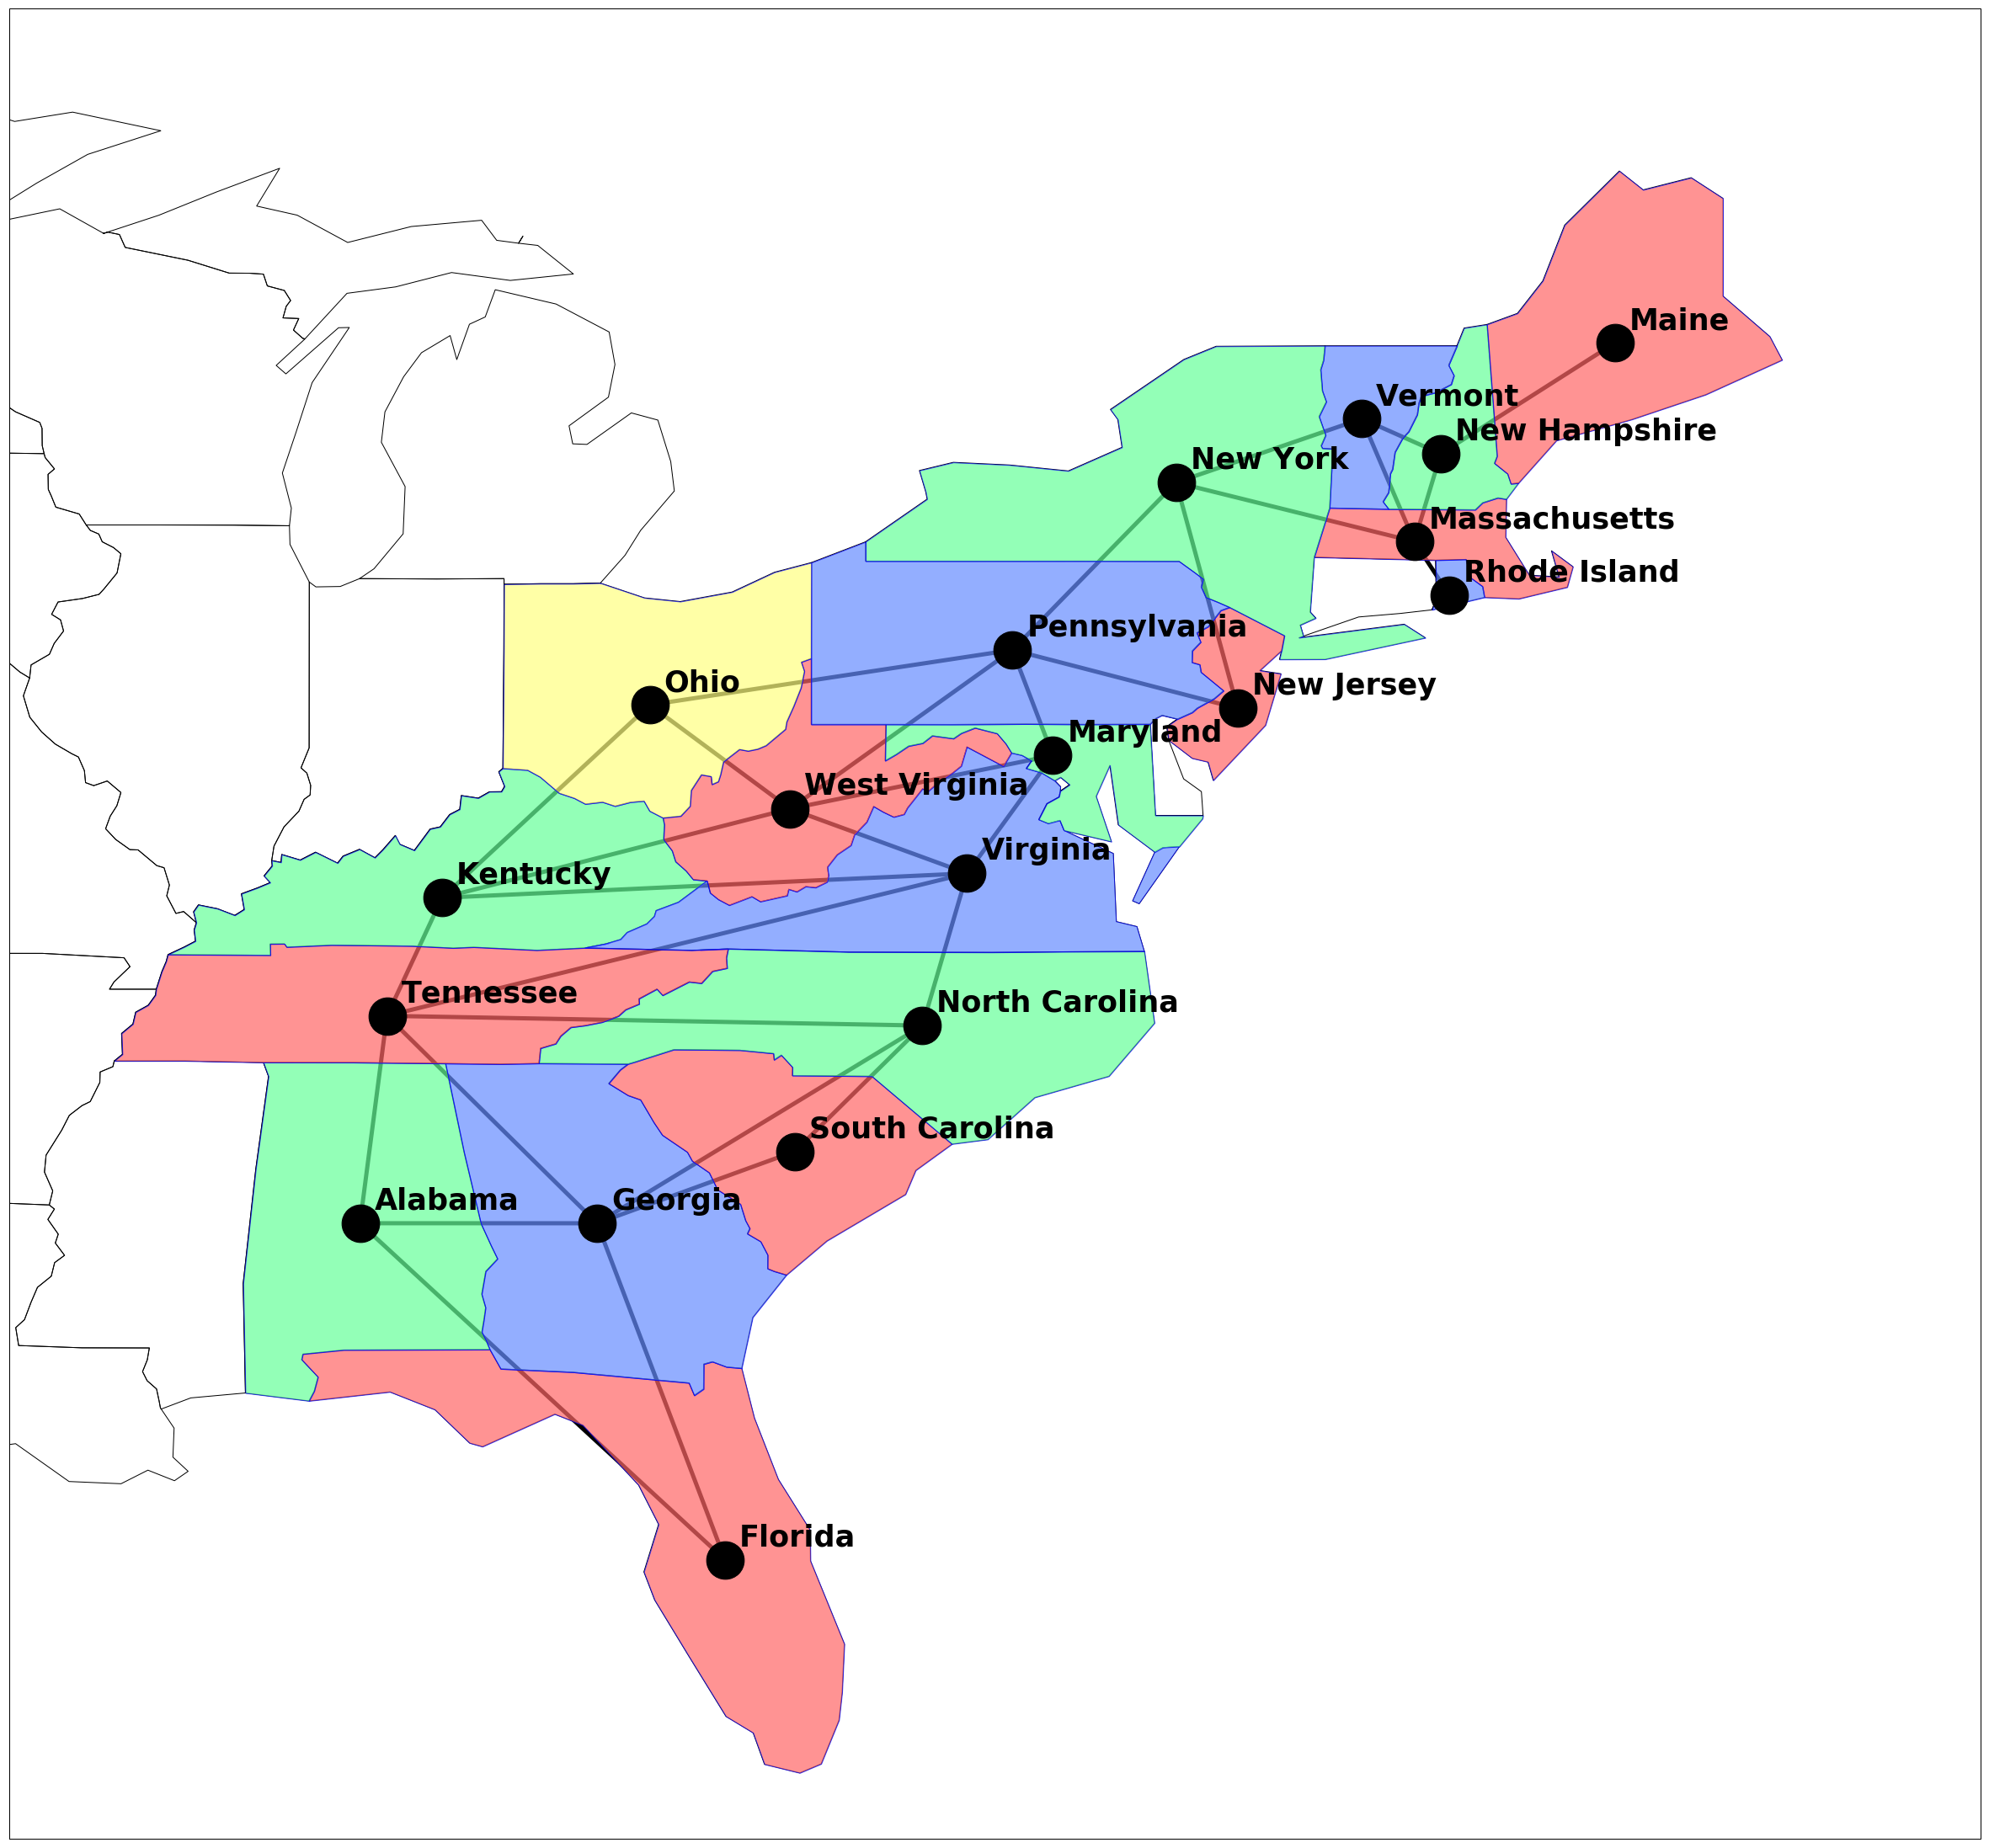

In [21]:
# east coast
plot_states(include=('ME', 'NH', 'RI', 'NY', 'OH', 'KY', 'VT', 'MA', 'PA', 'MD', 
                     'TN', 'AL', 'NJ', 'NY', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL'))

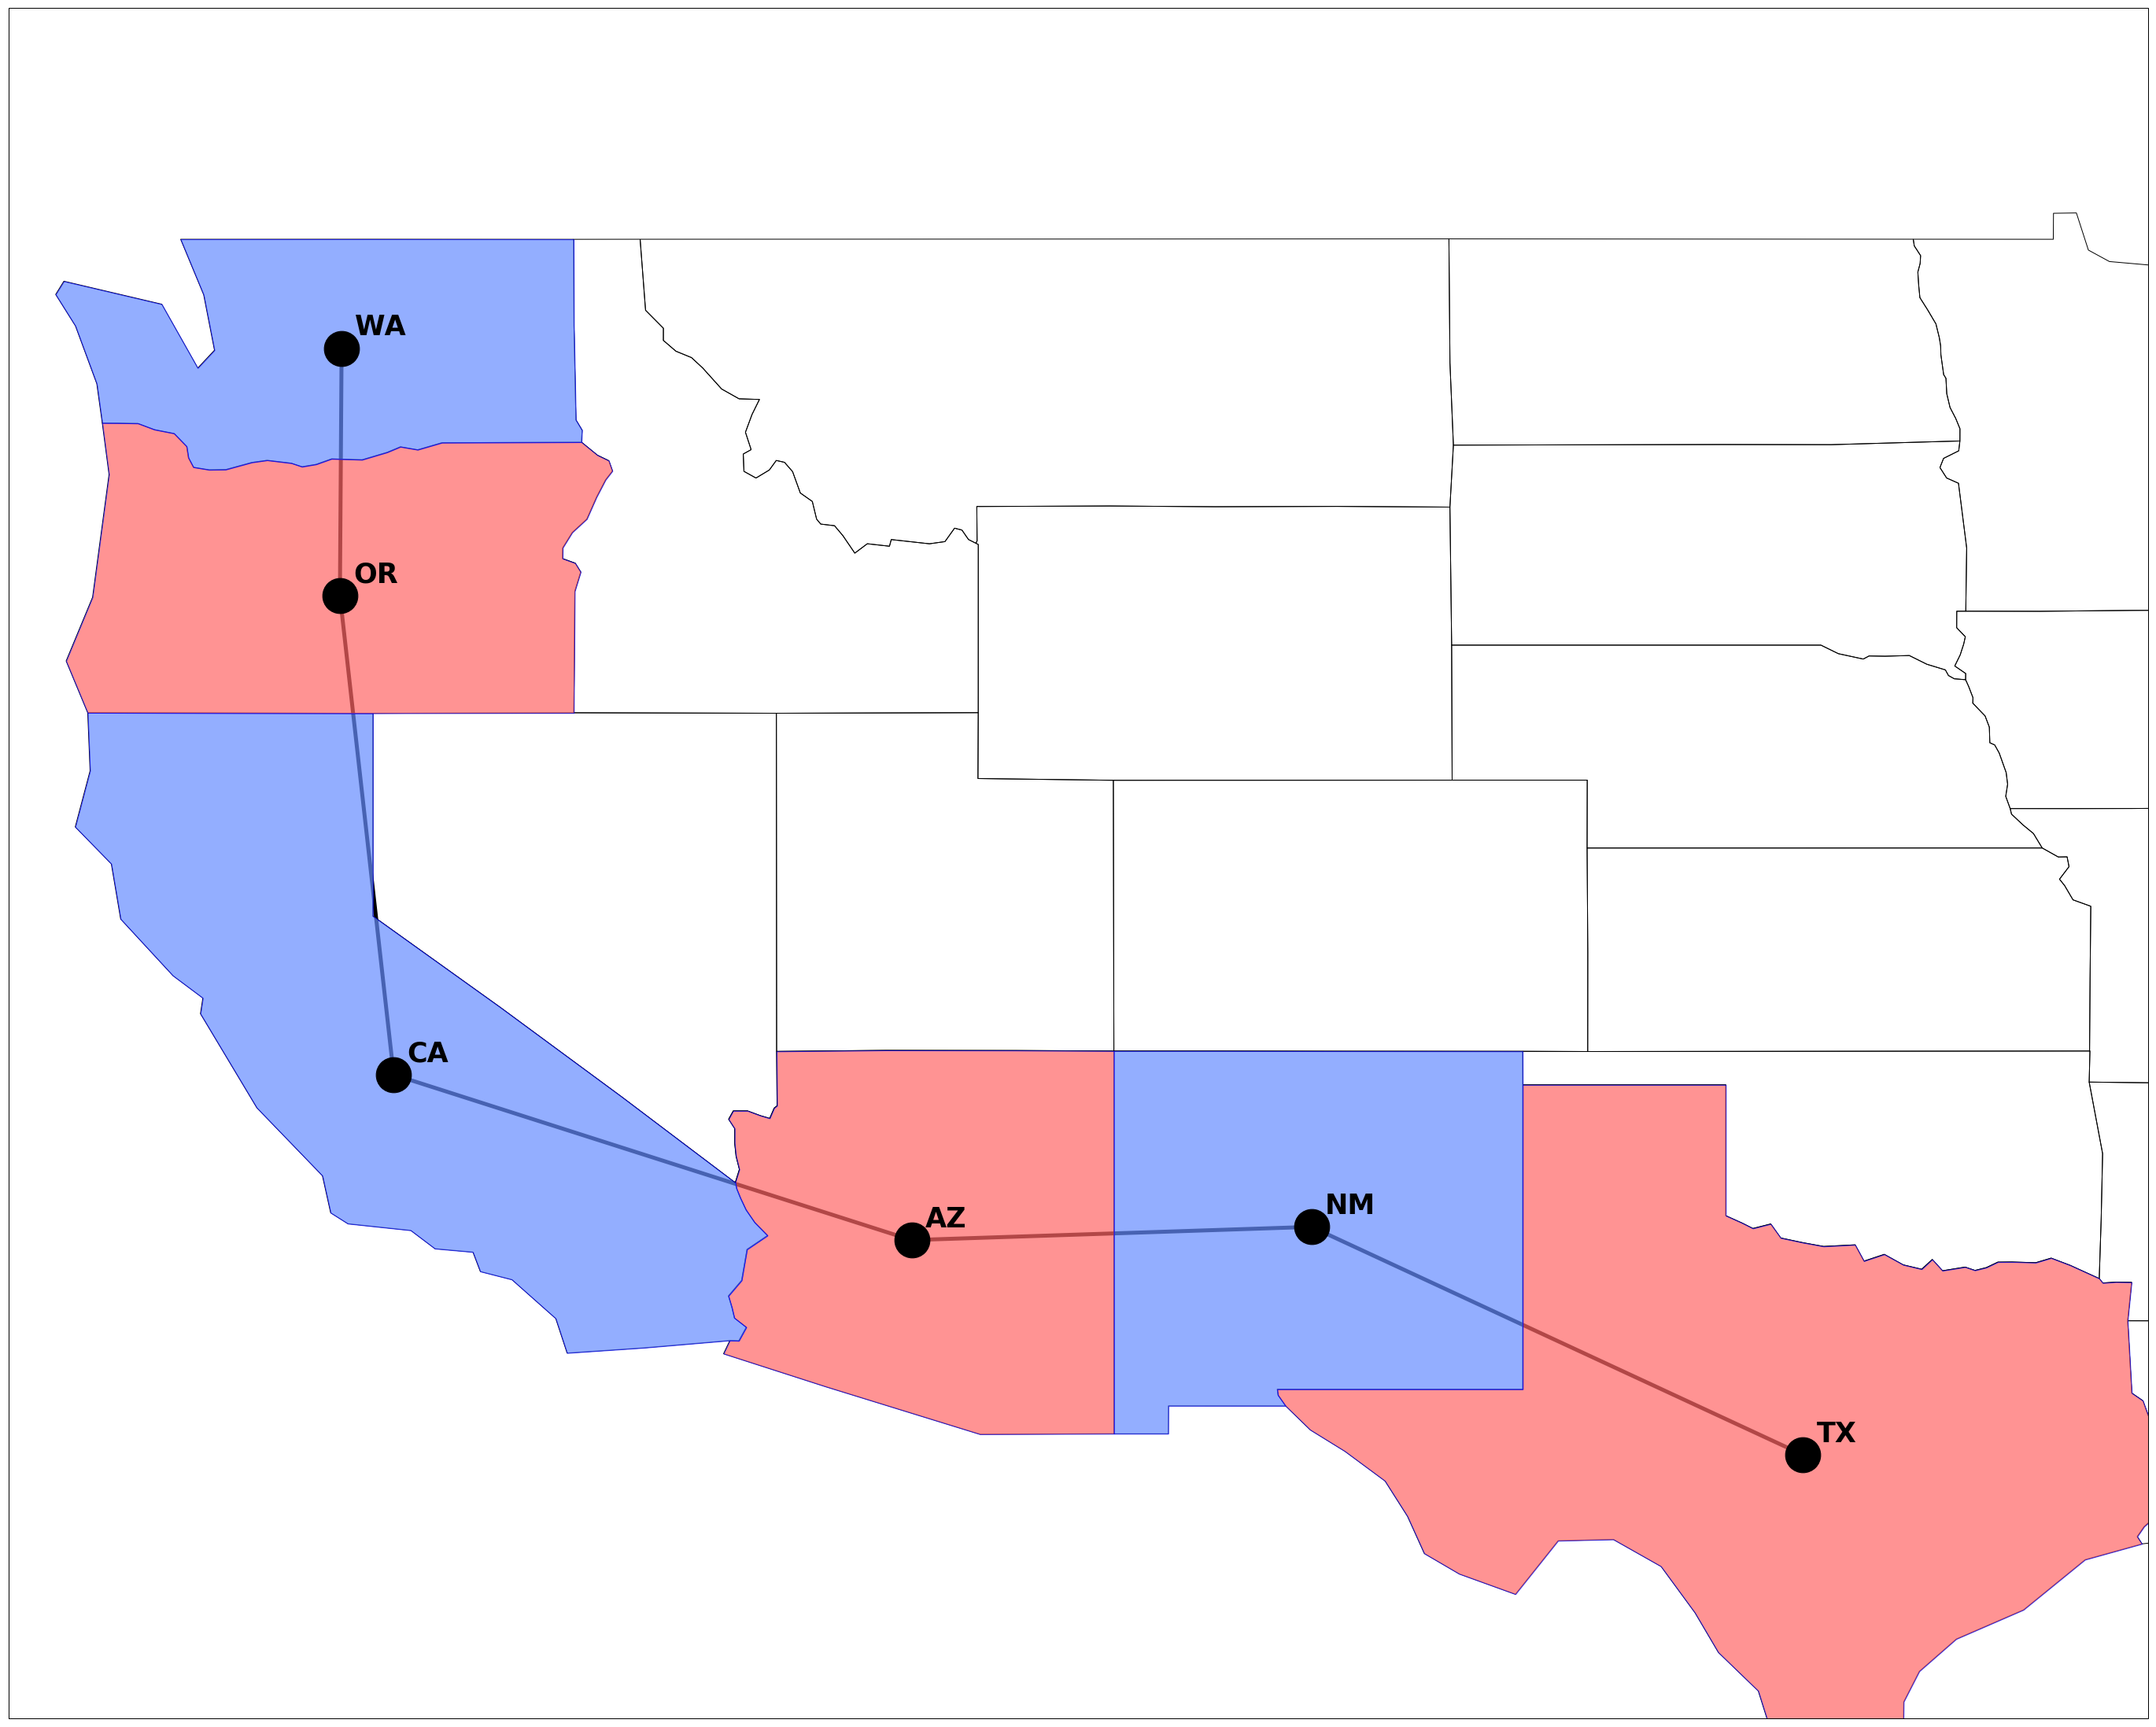

In [22]:
# chain - west coast
plot_states(include=('WA', 'OR', 'CA', 'AZ', 'NM', 'TX'))

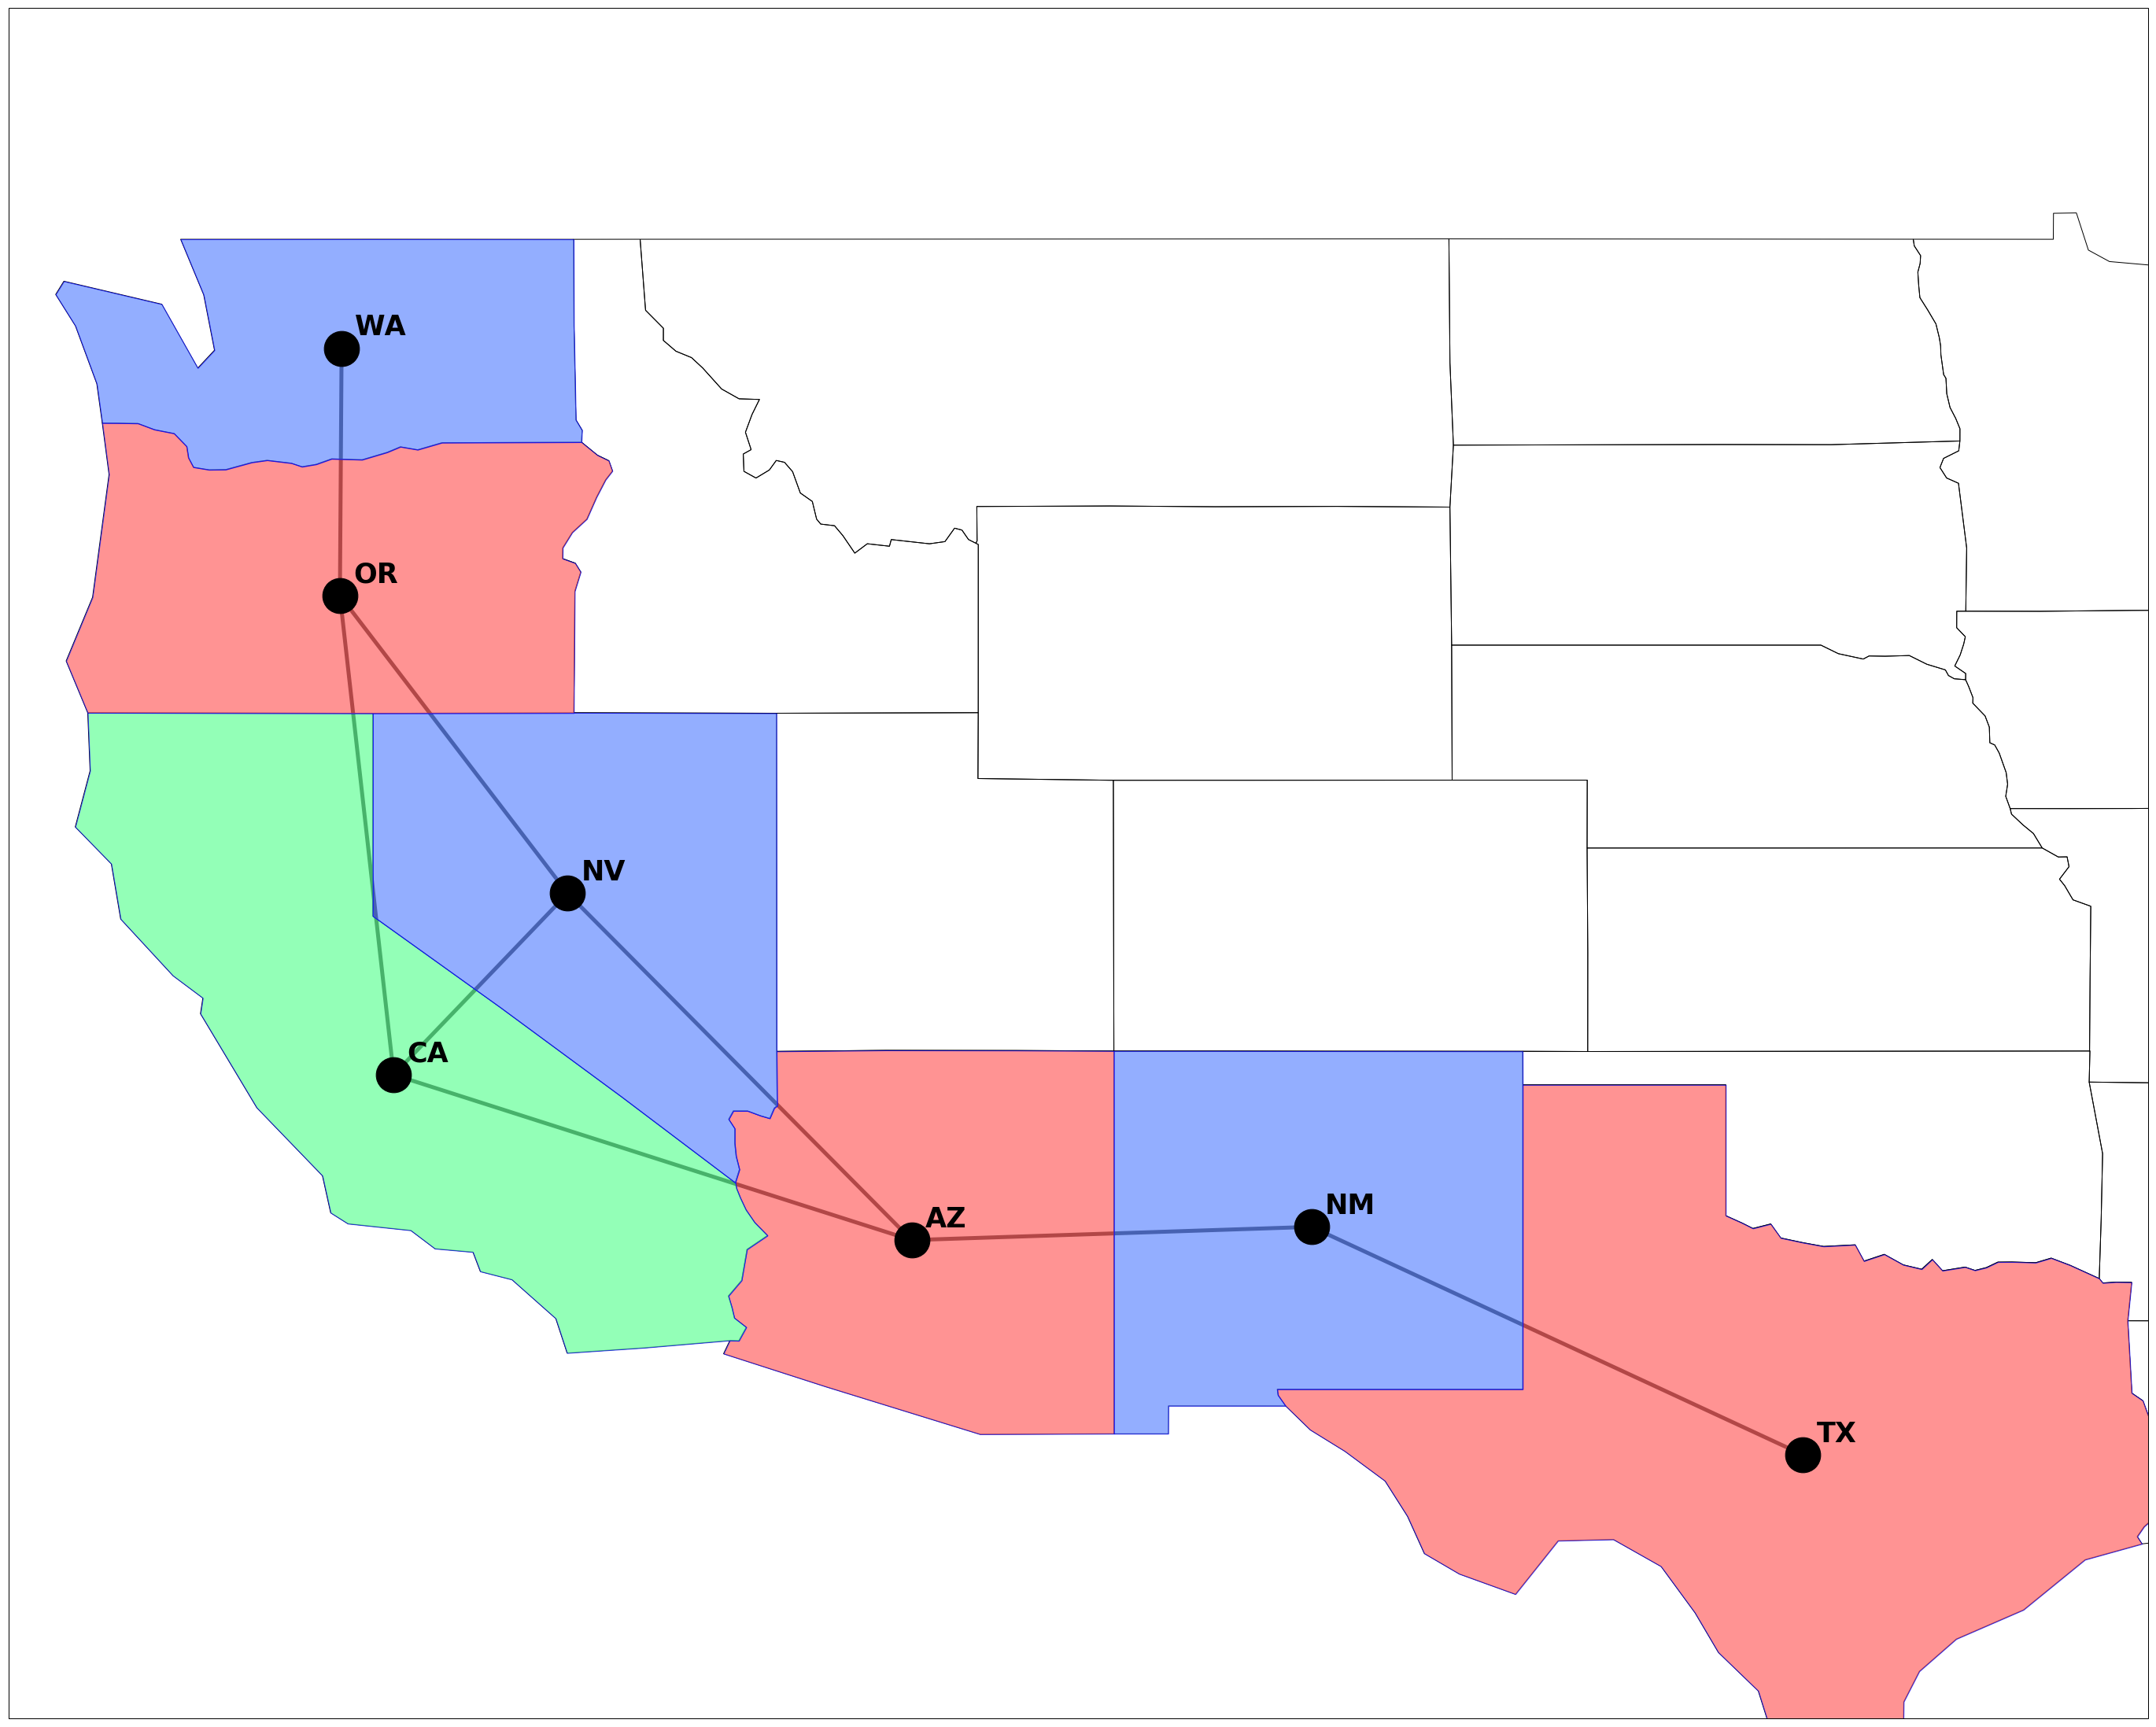

In [23]:
# not chain - west coast incl Nevada
plot_states(include=('WA', 'OR', 'CA', 'NV','AZ', 'NM', 'TX'))